<a href="https://colab.research.google.com/github/Jotadebeese/Rubbish-Classifier-Updated/blob/main/model_deployment/model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Model Deployment

## 0. Get setup

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the PyTorch Scripts directory, download it from GitHub
try:
    from modular_scripts import data_setup, engine, utils
except:
    # Get the scripts
    print("[INFO] Couldn't find scripts, downloading them from GitHub.")
    !git clone https://github.com/Jotadebeese/pytorch_scripts
    !mv pytorch_scripts/modular_scripts .
    !rm -rf pytorch_scripts
    from modular_scripts import data_setup, engine, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find scripts, downloading them from GitHub.
Cloning into 'pytorch_scripts'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 257 (delta 6), reused 12 (delta 6), pack-reused 242
Receiving objects: 100% (257/257), 61.20 KiB | 10.20 MiB/s, done.
Resolving deltas: 100% (143/143), done.
[INFO] splitfolders module not found. Installing...


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1. Getting Data

In [ ]:
from modular_scripts.utils import download_data

# Download the data
image_path = download_data(source='https://huggingface.co/datasets/Jotadebeese/rubbish_augmented/resolve/main/rubbish_dataset_augmented.zip?download=true',
                           destination='augmented_rubbish_dataset',
                           from_gdrive=False)

'data/augmented_rubbish_dataset' does not exist, creating directory...
[INFO] Downloading rubbish_dataset_augmented.zip?download=true from https://huggingface.co/datasets/Jotadebeese/rubbish_augmented/resolve/main/rubbish_dataset_augmented.zip?download=true...
[INFO] Unzipping rubbish_dataset_augmented.zip?download=true data...


In [ ]:
utils.bulk_image_convertor(dataset_path=str(image_path) + '/rubbish_dataset_augmented',
                    format="jpg")

3156it [00:00, 193317.51it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/metal'


3274it [00:02, 1595.04it/s]


66 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/cardboard'


5674it [00:01, 4165.57it/s]


42 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/glass'


593it [00:03, 150.59it/s]


125 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/trash'


3042it [00:00, 166780.90it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/plastic'


3692it [00:00, 147364.63it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/organic'


4228it [00:00, 189724.16it/s]

0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/paper'


In [ ]:
train_dir, test_dir, val_dir = utils.split_data(
    input_folder=str(image_path) + '/rubbish_dataset_augmented',
    output_folder=image_path
)
train_dir, test_dir, val_dir

Copying files: 23659 files [00:05, 3963.98 files/s]


(PosixPath('data/augmented_rubbish_dataset/train'),
 PosixPath('data/augmented_rubbish_dataset/test'),
 PosixPath('data/augmented_rubbish_dataset/val'))

## 2. Model Deployment Expetiment outline

**Ideal use case** A model that performs well and fast:

* Performs well: 95%+ accuracy.
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency).
  * Latency = time for prediction to take place.

To try and achieve these goals, we will build two model experiments:

1. EffNetB2 feature extractor.
2. ViT feature extractor.

## 3. EffNetB2 feature extractor

In [ ]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
  kwargs.pop("check_hash")
  return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

def create_effnetb2_model(num_classes: int = 7,
                          seed: int=42):
  """Creates a PyTorch EfficientNetB2 feature extractor"""
  # Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  # Get EffNetB2 transforms
  transforms = weights.transforms()
  # Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)
  # Freeze the base layers in the model
  for param in model.parameters():
    param.requires_grad = False
  # Create classifier
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=7,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 408MB/s]


In [ ]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 7]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating DataLoaders for EffNetB2

In [ ]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x786e3f79dc60>,
 ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash'])

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(592,
 75,
 ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash'])

### 3.2 Training EffNetB2 feature extractor

In [ ]:
from modular_scripts.utils import set_seeds
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Training function
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7229 | train_acc: 0.7754 | test_loss: 0.5047 | test_acc: 0.8417
Epoch: 2 | train_loss: 0.5018 | train_acc: 0.8331 | test_loss: 0.4465 | test_acc: 0.8571
Epoch: 3 | train_loss: 0.4779 | train_acc: 0.8364 | test_loss: 0.4269 | test_acc: 0.8567
Epoch: 4 | train_loss: 0.4591 | train_acc: 0.8426 | test_loss: 0.4087 | test_acc: 0.8696
Epoch: 5 | train_loss: 0.4422 | train_acc: 0.8438 | test_loss: 0.3933 | test_acc: 0.8721
Epoch: 6 | train_loss: 0.4420 | train_acc: 0.8462 | test_loss: 0.3889 | test_acc: 0.8704
Epoch: 7 | train_loss: 0.4393 | train_acc: 0.8485 | test_loss: 0.3738 | test_acc: 0.8804
Epoch: 8 | train_loss: 0.4379 | train_acc: 0.8497 | test_loss: 0.3726 | test_acc: 0.8729
Epoch: 9 | train_loss: 0.4332 | train_acc: 0.8498 | test_loss: 0.3728 | test_acc: 0.8804
Epoch: 10 | train_loss: 0.4323 | train_acc: 0.8491 | test_loss: 0.3710 | test_acc: 0.8792


### 3.3 Inspecting EffNet Loss Curves

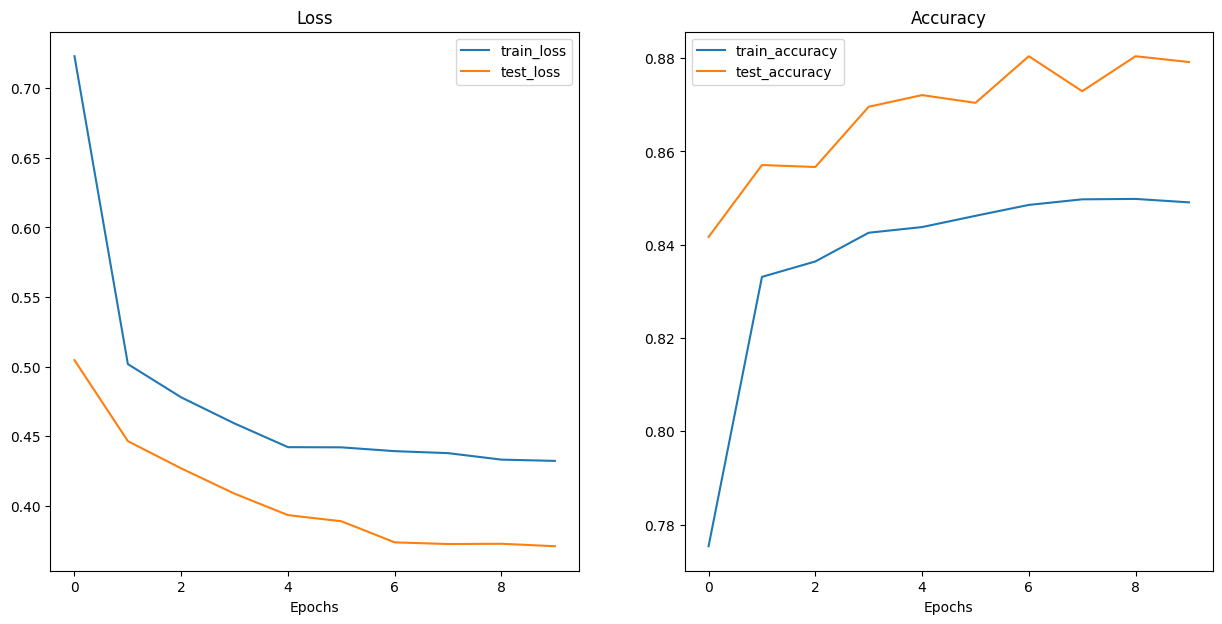

In [ ]:
utils.plot_loss_curves(results=effnetb2_results)

* Data Augmentation
* Train for longer

### 3.4 Saving EffNetB2 feature extractor

In [ ]:
# Saving the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_augmented_dataset_10_epochs.pth")

[INFO] Saving model to: models/effnetb2_augmented_dataset_10_epochs.pth


### 3.5 Inspecting the size of the model

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/effnetb2_augmented_dataset_10_epochs.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.6 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"EffNetB2 total parameters: {effnetb2_total_params}")

EffNetB2 total parameters: 7710857


In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.3709986170878013,
 'test_acc': 0.8791666666666667,
 'number_of_parameters': 7710857,
 'model_size (MB)': 29.86113929748535}

## 4. Creating ViT feature extractor

In [ ]:
def create_vit_model(num_classes:int=7,
                     seed:int=42):
  """Creates a PyTorch ViT pretrained feature extractor"""
  # Create Vit_B_16 pretrained weights, transforms and models
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights).to(device)

  # Freeze all the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )
  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=7,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:00<00:00, 438MB/s]


In [ ]:
from torchinfo import summary

summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 7]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Dataloaders for ViT feature extractor

In [ ]:
from modular_scripts.data_setup import create_dataLoaders

train_dataloader_vit, test_dataloader_vit, class_names = create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(592,
 75,
 ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash'])

### 4.2 Training ViT Feature Extractor

In [ ]:
from modular_scripts.engine import train
from modular_scripts.utils import set_seeds
# Set Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Train ViT
set_seeds()
vit_results = train(model=vit,
                    train_dataloader=train_dataloader_vit,
                    test_dataloader=test_dataloader_vit,
                    epochs=10,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4408 | train_acc: 0.8629 | test_loss: 0.3599 | test_acc: 0.8733
Epoch: 2 | train_loss: 0.2651 | train_acc: 0.9135 | test_loss: 0.3191 | test_acc: 0.8933
Epoch: 3 | train_loss: 0.2253 | train_acc: 0.9269 | test_loss: 0.3034 | test_acc: 0.9046
Epoch: 4 | train_loss: 0.2019 | train_acc: 0.9339 | test_loss: 0.2967 | test_acc: 0.9012
Epoch: 5 | train_loss: 0.1865 | train_acc: 0.9406 | test_loss: 0.2920 | test_acc: 0.9025
Epoch: 6 | train_loss: 0.1756 | train_acc: 0.9432 | test_loss: 0.2923 | test_acc: 0.9079
Epoch: 7 | train_loss: 0.1645 | train_acc: 0.9471 | test_loss: 0.2955 | test_acc: 0.9038
Epoch: 8 | train_loss: 0.1568 | train_acc: 0.9506 | test_loss: 0.2854 | test_acc: 0.9108
Epoch: 9 | train_loss: 0.1505 | train_acc: 0.9523 | test_loss: 0.2921 | test_acc: 0.9121
Epoch: 10 | train_loss: 0.1446 | train_acc: 0.9547 | test_loss: 0.2898 | test_acc: 0.9079


### 4.3 Plot Loss Curves of ViT feature extractor

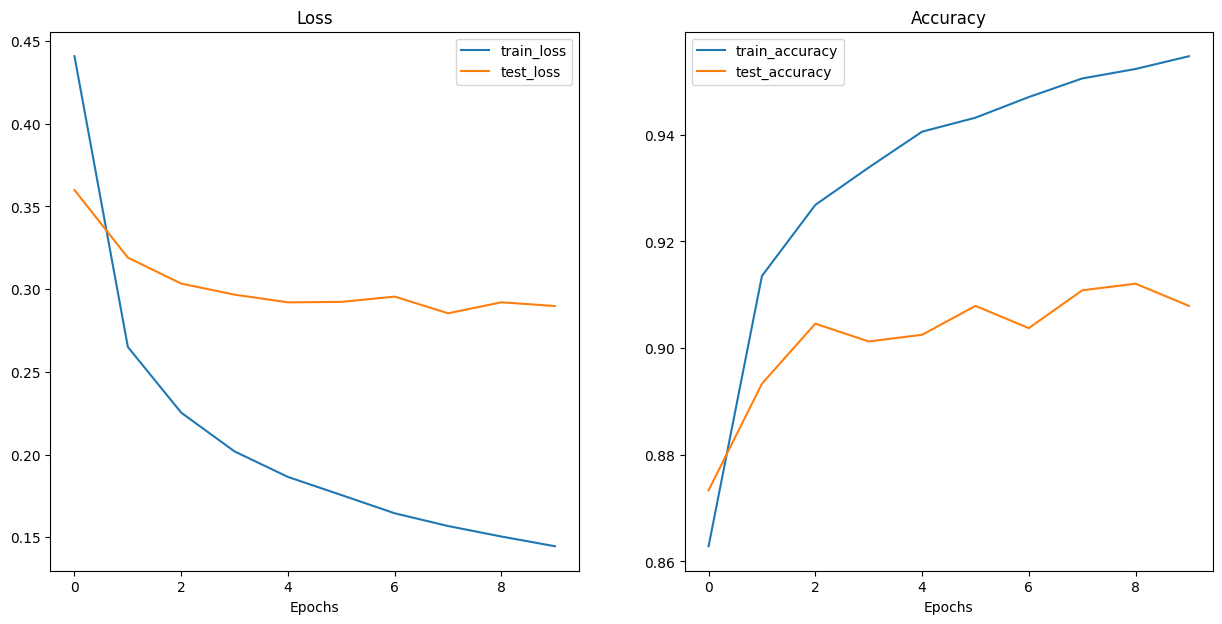

In [ ]:
from modular_scripts.utils import plot_loss_curves

plot_loss_curves(results=vit_results)

### 4.4 Saving ViT feature extractor

In [ ]:
# Save model
from modular_scripts.utils import save_model

save_model(model=vit,
           target_dir="models",
           model_name="vit_b_16_augmented_dataset_10_epochs.pth")

[INFO] Saving model to: models/vit_b_16_augmented_dataset_10_epochs.pth


### 4.5 Checking the model size


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/vit_b_16_augmented_dataset_10_epochs.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size:.2f} MB")

Pretrained ViT feature extractor model size: 327.38 MB


### 4.6 Collecting ViT features extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.28981455804624906,
 'test_acc': 0.9079166666666667,
 'number_of_parameters': 85804039,
 'model_size (MB)': 327.37833976745605}

## 5. Make predictions and time them

In [ ]:
from pathlib import Path

val_data_path = list(Path(val_dir).glob("*/*.jpg"))


### 5.1 Function to make predictions across val dataset

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    for path in tqdm(paths):
      pred_dict = {}
      pred_dict["image_path"] = path
      class_name = path.parent.stem
      pred_dict["class_name"] = class_name

      start_time = timer()
      img = Image.open(path)
      transformed_img = transform(img).unsqueeze(dim=0).to(device)

      model = model.to(device)
      model.eval()

      with torch.inference_mode():
        pred_logit = model(transformed_img)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class

        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time - start_time, 4)

      pred_dict["Correct"] = class_name == pred_class
      pred_list.append(pred_dict)

    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Two thing to nore:
1. **Device** - hardcode predictions to happen on CPU (There won't be always a GPU when deploying a model)
2. **Transforms** - Make sure the images used for prediction have been previously prepared with the appropiate transforms to the model on use (e.g EffNetB2 with `effnetb2_transforms`)

In [ ]:
# Make predictions val dataset with EffNetB2
effnetb2_val_pred_dicts = pred_and_store(paths=val_data_path,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device="cpu")

  0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Turn the val_pred_dicts into a DataFrame
import pandas as pd
effnetb2_val_pred_df = pd.DataFrame(effnetb2_val_pred_dicts)
effnetb2_val_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,Correct
0,data/augmented_rubbish_dataset/val/metal/image...,metal,0.8800,metal,0.2313,True
1,data/augmented_rubbish_dataset/val/metal/143.jpg,metal,0.4191,metal,0.0597,True
2,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9834,metal,0.0551,True
3,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9561,metal,0.0558,True
4,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9967,metal,0.0514,True


In [ ]:
# Check number of correct predictions
effnetb2_val_pred_df.Correct.value_counts()

True     2107
False     256
Name: Correct, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_val_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.0733


> **Note**: Prediction times will vary (much like training times) depending on the hardware you're using. The faster the compute (e.g CPU or GPU), the faster the predictions.

In [ ]:
# Add average time per pred on CPU to the effnetb2_stats
effnetb2_stats["time_for_pred_on_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.3709986170878013,
 'test_acc': 0.8791666666666667,
 'number_of_parameters': 7710857,
 'model_size (MB)': 29.86113929748535,
 'time_for_pred_on_cpu': 0.0733}

### 5.3 Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor
vit_val_pred_dicts = pred_and_store(paths=val_data_path,
                                    model=vit,
                                    transform=vit_transforms,
                                    class_names=class_names,
                                    device="cpu")

  0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
# Turn the val_pred_dicts into a DataFrame
import pandas as pd
vit_val_pred_df = pd.DataFrame(vit_val_pred_dicts)
vit_val_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,Correct
0,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9996,metal,0.2828,True
1,data/augmented_rubbish_dataset/val/metal/143.jpg,metal,0.9819,metal,0.1253,True
2,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9992,metal,0.1334,True
3,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9056,metal,0.1408,True
4,data/augmented_rubbish_dataset/val/metal/image...,metal,0.9983,metal,0.1220,True


In [ ]:
# See how many correct
vit_val_pred_df.Correct.value_counts()

True     2189
False     174
Name: Correct, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_val_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.1388


In [ ]:
# Add average time per prediction to ViT stats
vit_stats["time_for_pred_on_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.28981455804624906,
 'test_acc': 0.9079166666666667,
 'number_of_parameters': 85804039,
 'model_size (MB)': 327.37833976745605,
 'time_for_pred_on_cpu': 0.1388}

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])
# Add column for model names
df["model"] = ["EffNetB2", "ViT"]
# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_for_pred_on_cpu,model
0,0.370999,87.92,7710857,29.861139,0.0733,EffNetB2
1,0.289815,90.79,85804039,327.378340,0.1388,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_for_pred_on_cpu
ViT to EffNetB2 ratios,0.781174,1.032643,11.127692,10.963357,1.893588


### 6.1 Visualizing the speed vs. performance tradeoff

Visualize the comparison with a speed vs. performance plot.

Steps:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

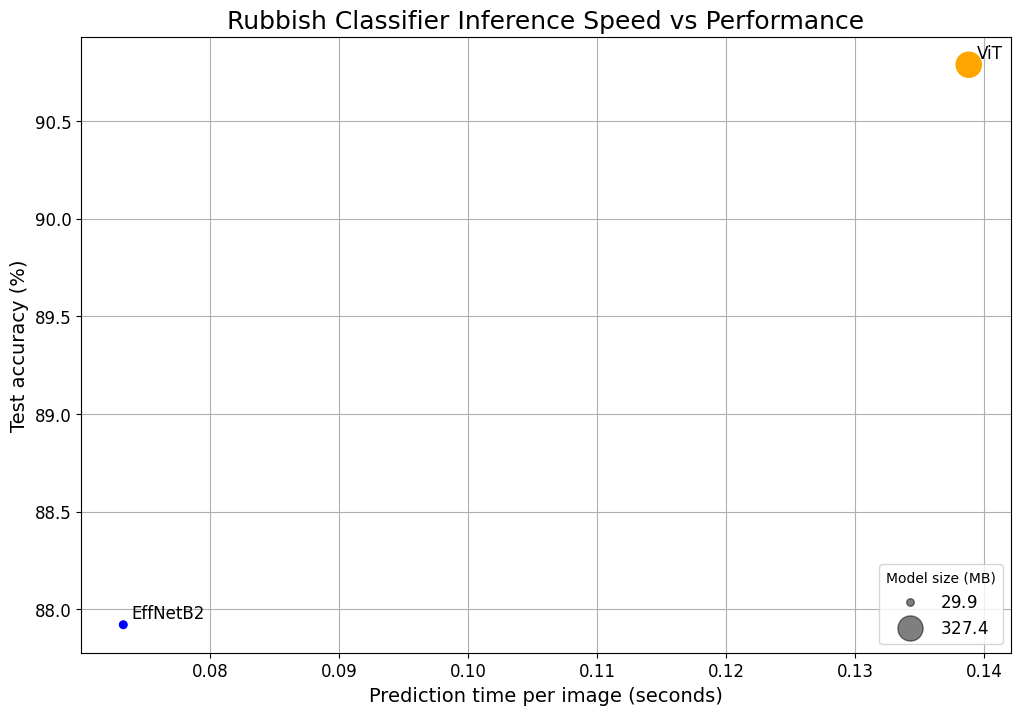

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_for_pred_on_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels
ax.set_title("Rubbish Classifier Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_for_pred_on_cpu"]+0.0006, row["test_acc"]+0.03),
              size=12)

# 4. Created a legend based on the model size (model_size (MB))
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the image
plt.savefig("rubbish_classifier_inference_speed_vs_performance.png")

## 7. Creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.5 MB/s eta 0:00:00
Gradio version: 4.21.0


### 7.1 Gradio Overview

inputs -> function/model -> ouputs

### 7.2 Creating a function to map out inputs and outputs

In [ ]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")
vit = vit.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device
next(iter(vit.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
trash images -> ML model -> outputs (rubblish class label, prediction time)
```

In [ ]:
from typing import Tuple, Dict

def predict(img, model_str: str) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()
  if model_str == "effnetb2":
    # Transform the image
    img = effnetb2_transforms(img).unsqueeze(0)
    model = effnetb2
  elif model_str == "vit":
    # Transform the image
    img = vit_transforms(img).unsqueeze(0)
    model = vit

  # Put model into eval mode, make prediction
  model.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(model(img), dim=1)
  # Create a prediciton label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  # Calculate pred time
  pred_time = round(timer() - start_time, 4)
  # Return pred labels and pred time
  return pred_labels_and_probs, pred_time


In [ ]:
import random
from PIL import Image

val_data_paths = list(Path(val_dir).glob("*/*.jpg"))
random_image_path = random.choice(val_data_paths)
random_image_path

# Open the target Image
img = Image.open(random_image_path)
print (f"[INFO] Predictiting on image at path: {random_image_path}")

# Predict on the target image and print out outputs
pred_dict, pred_time = predict(img, 'vit')
print(f"[INFO] Prediction time: {pred_time} seconds")
print(f"[INFO] Prediction Dict: {pred_dict}")

[INFO] Predictiting on image at path: data/augmented_rubbish_dataset/val/organic/image_2453.jpg
[INFO] Prediction time: 0.13 seconds
[INFO] Prediction Dict: {'cardboard': 7.299934077309445e-05, 'glass': 0.0013766518095508218, 'metal': 0.00039292051224038005, 'organic': 0.9977495074272156, 'paper': 0.00020193243108224124, 'plastic': 0.0001994015765376389, 'trash': 6.71254792905529e-06}


### 7.3 Create a list of examples images

The examples for gradio can be created with the `examples` parameter.

In [ ]:
example_list = [[str(filepath)] for filepath in random.sample(val_data_paths, 3)]
example_list

[['data/augmented_rubbish_dataset/val/plastic/39.jpg'],
 ['data/augmented_rubbish_dataset/val/glass/image_7125.jpg'],
 ['data/augmented_rubbish_dataset/val/metal/image_13708.jpg']]

### 7.4 Building a Gradio Interface

In [ ]:
import gradio as gr

# Create title, description and article
title = "Rubbish Classifier 🗑️"
description = "An [EfficientNetb2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) and a [ViT feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) model to classify rubbish images."
article = "Created by me"

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=[gr.Image(type="pil"),
                            gr.Dropdown(choices=['effnetb2', 'vit'], label='Model To Use', value='effnetb2')],
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://22585073cfbeb9150e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning Rubbish Classifier Gradio Demo into a deployable app on Hugging Face

### 8.1 Deployed Gradio App Structure

```
demos/
└── rubbish_classifier/
    ├── effnetb2_augmented_dataset_10_epochs.pth
    ├── vit_b_16_augmented_dataset_10_epochs.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 8.2 Creating a `demos` foldet to store our app files

In [ ]:
import shutil
from pathlib import Path

# Create path
rubbish_classifier_demo_path = Path("demos/rubbish_classifier")

# Remove file that might exist and create a new directory
if rubbish_classifier_demo_path.exists():
  shutil.rmtree(rubbish_classifier_demo_path)
  rubbish_classifier_demo_path.mkdir(parents=True, exist_ok=True)
else:
  rubbish_classifier_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/rubbish_classifier/

### 8.3 Creating a folder of images to use with the Rubbish Classifier

In [67]:
import shutil
from pathlib import Path

# Create an examples directory
rubbish_classifier_examples_path = rubbish_classifier_demo_path / "examples"
rubbish_classifier_examples_path.mkdir(parents=True, exist_ok=True)

# Collects three val data set images paths
rubbish_classifier_examples = [random.choice(list(label_dir.glob('*.jpg'))) for label_dir in Path('data/augmented_rubbish_dataset/val').iterdir() if label_dir.is_dir()]

# Copy the three images to the examples directory
for example in rubbish_classifier_examples:
  destination = rubbish_classifier_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/augmented_rubbish_dataset/val/metal/image_12178.jpg to demos/rubbish_classifier/examples/image_12178.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/cardboard/image_6387.jpg to demos/rubbish_classifier/examples/image_6387.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/glass/image_7205.jpg to demos/rubbish_classifier/examples/image_7205.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/trash/image_19775.jpg to demos/rubbish_classifier/examples/image_19775.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/plastic/image_18981.jpg to demos/rubbish_classifier/examples/image_18981.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/organic/image_484.jpg to demos/rubbish_classifier/examples/image_484.jpg
[INFO] Copying data/augmented_rubbish_dataset/val/paper/image_14286.jpg to demos/rubbish_classifier/examples/image_14286.jpg


Get a list of lists from the `examples/` directory

In [68]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(rubbish_classifier_examples_path)]
example_list

[['examples/image_19775.jpg'],
 ['examples/image_484.jpg'],
 ['examples/image_6387.jpg'],
 ['examples/image_14286.jpg'],
 ['examples/image_7205.jpg'],
 ['examples/image_6237.jpg'],
 ['examples/image_10904.jpg'],
 ['examples/image_1227.jpg'],
 ['examples/image_17309.jpg'],
 ['examples/image_19472.jpg'],
 ['examples/image_12214.jpg'],
 ['examples/image_12178.jpg'],
 ['examples/IMG_0602.jpg'],
 ['examples/image_18981.jpg']]

### 8.4 Moving trained models to Rubbish Demo Directory

In [ ]:
import shutil

# Create source paths for our target models
effnetb2_augmented_dataset_10_epochs_path = "models/effnetb2_augmented_dataset_10_epochs.pth"
vit_b_16_augmented_dataset_10_epochs_path = "models/vit_b_16_augmented_dataset_10_epochs.pth"

# Create a destination path for out target models
effnetb2_augmented_dataset_10_epochs_destination = rubbish_classifier_demo_path / effnetb2_augmented_dataset_10_epochs_path.split("/")[1]
vit_b_16_augmented_dataset_10_epochs_destination = rubbish_classifier_demo_path / vit_b_16_augmented_dataset_10_epochs_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Moving {effnetb2_augmented_dataset_10_epochs_path} to {effnetb2_augmented_dataset_10_epochs_destination}")
  shutil.move(src=effnetb2_augmented_dataset_10_epochs_path, dst=effnetb2_augmented_dataset_10_epochs_destination)
  print(f"[INFO] Model move completed")
# If the model has already been moved, check if it exist
except:
  print(f"")
  print(f"[INFO] No model found at {effnetb2_augmented_dataset_10_epochs_path}")
  print(f"[INFO] Model exists at {effnetb2_augmented_dataset_10_epochs_destination}: {effnetb2_augmented_dataset_10_epochs_destination.exists()}")

try:
  print(f"")
  print(f"[INFO] Moving {vit_b_16_augmented_dataset_10_epochs_path} to {vit_b_16_augmented_dataset_10_epochs_destination}")
  shutil.move(src=vit_b_16_augmented_dataset_10_epochs_path, dst=vit_b_16_augmented_dataset_10_epochs_destination)
  print(f"[INFO] Model move completed")
# If the model has already been moved, check if it exist
except:
  print(f"")
  print(f"[INFO] No model found at {vit_b_16_augmented_dataset_10_epochs_path}")
  print(f"[INFO] Model exists at {vit_b_16_augmented_dataset_10_epochs_destination}: {vit_b_16_augmented_dataset_10_epochs_destination.exists()}")

[INFO] Moving models/effnetb2_augmented_dataset_10_epochs.pth to demos/rubbish_classifier/effnetb2_augmented_dataset_10_epochs.pth

[INFO] No model found at models/effnetb2_augmented_dataset_10_epochs.pth
[INFO] Model exists at demos/rubbish_classifier/effnetb2_augmented_dataset_10_epochs.pth: True

[INFO] Moving models/vit_b_16_augmented_dataset_10_epochs.pth to demos/rubbish_classifier/vit_b_16_augmented_dataset_10_epochs.pth

[INFO] No model found at models/vit_b_16_augmented_dataset_10_epochs.pth
[INFO] Model exists at demos/rubbish_classifier/vit_b_16_augmented_dataset_10_epochs.pth: True


### 8.5 Turning off function model into a Python Script

In [ ]:
%%writefile demos/rubbish_classifier/model.py

import torch
import torch.nn as nn
import torchvision


def create_effnetb2_model(num_classes: int = 7,
                          seed: int=42):
  """Creates a PyTorch EfficientNetB2 feature extractor"""
  # Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  # Get EffNetB2 transforms
  transforms = weights.transforms()
  # Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights)
  # Freeze the base layers in the model
  for param in model.parameters():
    param.requires_grad = False
  # Create classifier
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms

def create_vit_model(num_classes:int=7,
                     seed:int=42):
  """Creates a PyTorch ViT pretrained feature extractor"""
  # Create Vit_B_16 pretrained weights, transforms and models
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )
  return model, transforms


Overwriting demos/rubbish_classifier/model.py


### 8.6 Turning our Gradio App into a Pythin script (`app.py`)

Four parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - Gradio interface + launch command

In [69]:
%%writefile demos/rubbish_classifier/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
from model import create_effnetb2_model, create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict
  # Setup class names
class_names = ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names),
)
vit, vit_transforms = create_vit_model(
    num_classes=len(class_names),
)
  # Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_augmented_dataset_10_epochs.pth"
        map_location=torch.device("cpu")
    )
)
vit.load_state_dict(
    torch.load(
        f="vit_b_16_augmented_dataset_10_epochs.pth"
        map_location=torch.device("cpu")
    )
)
### 3. Predict function ###
def predict(img, model_str: str) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()
  if model_str == "effnetb2":
    # Transform the image
    img = effnetb2_transforms(img).unsqueeze(0)
    model = effnetb2
  elif model_str == "vit":
    # Transform the image
    img = vit_transforms(img).unsqueeze(0)
    model = vit

  # Put model into eval mode, make prediction
  model.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(model(img), dim=1)
  # Create a prediciton label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  # Calculate pred time
  pred_time = round(timer() - start_time, 4)
  # Return pred labels and pred time
  return pred_labels_and_probs, pred_time
### 4. Gradio app - Gradio interface + launch command ###
  # Create title, description and article
title = "Rubbish Classifier 🗑️"
description = "An [EfficientNetb2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) and a [ViT feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) model to classify rubbish images."
article = "Created by me"
  # Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]
  # Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=[gr.Image(type="pil"),
                            gr.Dropdown(choices=['effnetb2', 'vit'], label='Model To Use', value='effnetb2')],
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

  # Launch the demo
demo.launch(share=True)


Writing demos/rubbish_classifier/app.py


### 8.7 Creating `requiremenets.txt`

The requirements file will tell Hugging Face Space what software dependencies our app requires.

* `gradio`
* `torch`
* `torchvision`

In [74]:
%%writefile demos/rubbish_classifier/requirements.txt
gradio==4.21.0
torch==2.2.1
torchvision==0.17.1

Writing demos/rubbish_classifier/requirements.txt


## 9. Deploying our Rubbish Classifier to HuggingFace Spaces

### 9.1 Downloading app files

In [77]:
!cd demos/rubbish_classifier && zip -r ../rubbish_classifier.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 60%)
  adding: effnetb2_augmented_dataset_10_epochs.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/image_19775.jpg (deflated 7%)
  adding: examples/image_484.jpg (deflated 19%)
  adding: examples/image_6387.jpg (deflated 7%)
  adding: examples/image_14286.jpg (deflated 9%)
  adding: examples/image_7205.jpg (deflated 40%)
  adding: examples/image_6237.jpg (deflated 1%)
  adding: examples/image_10904.jpg (deflated 13%)
  adding: examples/image_1227.jpg (deflated 1%)
  adding: examples/image_17309.jpg (deflated 6%)
  adding: examples/image_19472.jpg (deflated 12%)
  adding: examples/image_12214.jpg (deflated 1%)
  adding: examples/image_12178.jpg (deflated 5%)
  adding: examples/IMG_0602.jpg (deflated 0%)
  adding: examples/image_18981.jpg (deflated 4%)
  adding: model.py (deflated 63%)
  adding: requirements.txt (deflated 8%)
  adding: vit_b_16_augmented_dataset_10_epochs.pth (deflated 7%)


In [80]:
# Download
try:
  from google.colab import files
  files.download("demos/rubbish_classifier.zip")
except:
  print("Not running in Google Colab, can't use google.colab.files.donwload(), please download rubbish_classifier.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Uploading to Hugging Face

[Rubbish Classifier Gradio App](https://huggingface.co/spaces/Jotadebeese/rubbish_classifier)

In [82]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Jotadebeese/rubbish_classifier/+", width=900, height=750)